In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

C:\Users\dipes\AppData\Local\Temp\ipykernel_44260\3808743274.py:84: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rom_rad = np.trapz(yy, tt)
C:\Users\dipes\AppData\Local\Temp\ipykernel_44260\3808743274.py:91: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  jerk = np.trapz(dv**2, tt)



=== SESSION SUMMARY ===
Total detected reps: 5
Valid reps: 4

--- Aggregate metrics ---
Mean ROM (deg): 27.70
Median ROM (deg): 26.69
Mean jerk: 14.91
Mean cv_speed: 0.42

--- Best rep ---
rep          2.000000
dur_s        3.109997
rom_deg     44.929456
peak_dw      0.952753
mean_dw      0.251879
cv_speed     0.488587
jerk        40.057436
Name: 0, dtype: float64

--- Worst rep (control) ---
rep          2.000000
dur_s        3.109997
rom_deg     44.929456
peak_dw      0.952753
mean_dw      0.251879
cv_speed     0.488587
jerk        40.057436
Name: 0, dtype: float64

--- Fatigue trends ---
ROM slope (deg/rep): -11.97
Jerk slope (per rep): -11.15


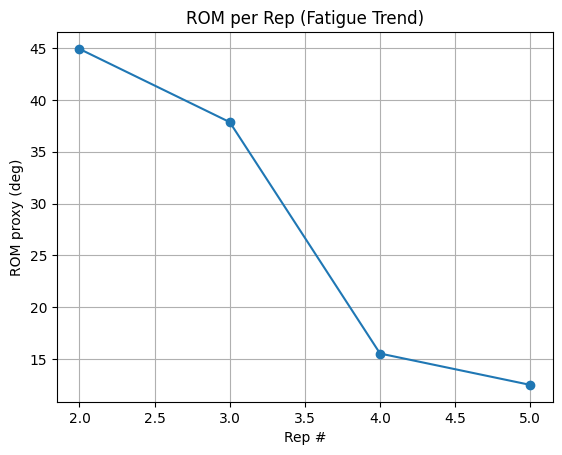

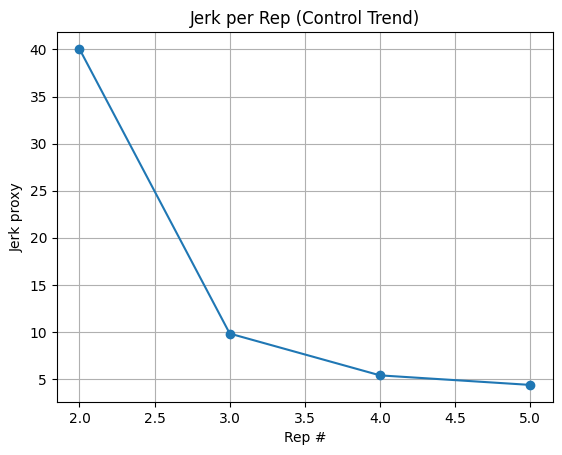

In [2]:

CSV_PATH = "dual_mpu_capture.csv"

# ---------- Segmentation + smoothness params ----------
SMOOTH_WIN = 7
START_THR = 0.22
STOP_THR  = 0.12
MIN_REP_DUR_S = 0.35
MIN_REST_S    = 0.15

# ---------- Session filters ----------
MIN_VALID_DUR_S = 0.8
MIN_VALID_ROM_DEG = 10.0
# -----------------------------------

def moving_avg(x, win):
    if win <= 1:
        return x.copy()
    k = np.ones(win) / win
    return np.convolve(x, k, mode="same")

def segment_reps(t, dw_s, fs):
    min_rep_n  = int(np.ceil(MIN_REP_DUR_S * fs))
    min_rest_n = int(np.ceil(MIN_REST_S * fs))

    reps = []
    state = 0
    rep_start_i = None
    peak_i = None
    peak_val = -np.inf
    below_count = 0

    for i, v in enumerate(dw_s):
        if state == 0:
            if v >= START_THR:
                state = 1
                rep_start_i = i
                peak_i = i
                peak_val = v
                below_count = 0

        elif state == 1:
            if v > peak_val:
                peak_val = v
                peak_i = i

            if v <= STOP_THR:
                below_count += 1
                if below_count >= min_rest_n:
                    rep_end_i = i
                    if rep_end_i - rep_start_i >= min_rep_n:
                        reps.append((rep_start_i, rep_end_i))
                    state = 0
                    below_count = 0
            else:
                below_count = 0
    return reps

def main():
    df = pd.read_csv(CSV_PATH)
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna().reset_index(drop=True)

    # time
    t = (df["T_US"] - df["T_US"].iloc[0]) / 1e6
    t = t.to_numpy()
    dt = np.median(np.diff(t))
    fs = 1.0 / dt if dt > 0 else 100.0

    # relative angular velocity
    w1 = df[["G1X","G1Y","G1Z"]].to_numpy()
    w2 = df[["G2X","G2Y","G2Z"]].to_numpy()
    dw_mag = np.linalg.norm(w1 - w2, axis=1)
    dw_s   = moving_avg(dw_mag, SMOOTH_WIN)

    reps = segment_reps(t, dw_s, fs)

    rows = []
    for i, (si, ei) in enumerate(reps, 1):
        tt = t[si:ei+1]
        yy = dw_mag[si:ei+1]

        dur = tt[-1] - tt[0]
        rom_rad = np.trapz(yy, tt)
        rom_deg = rom_rad * 180 / np.pi

        peak = np.max(yy)
        mean = np.mean(yy)
        cv   = np.std(yy) / mean if mean > 1e-6 else np.nan
        dv   = np.gradient(yy, tt)
        jerk = np.trapz(dv**2, tt)

        rows.append({
            "rep": i,
            "dur_s": dur,
            "rom_deg": rom_deg,
            "peak_dw": peak,
            "mean_dw": mean,
            "cv_speed": cv,
            "jerk": jerk
        })

    reps_df = pd.DataFrame(rows)

    # ---------- Filter valid reps ----------
    valid = reps_df[
        (reps_df["dur_s"] >= MIN_VALID_DUR_S) &
        (reps_df["rom_deg"] >= MIN_VALID_ROM_DEG)
    ].reset_index(drop=True)

    print("\n=== SESSION SUMMARY ===")
    print(f"Total detected reps: {len(reps_df)}")
    print(f"Valid reps: {len(valid)}")

    if len(valid) == 0:
        print("No valid reps. Adjust thresholds or movement style.")
        return

    print("\n--- Aggregate metrics ---")
    print(f"Mean ROM (deg): {valid['rom_deg'].mean():.2f}")
    print(f"Median ROM (deg): {valid['rom_deg'].median():.2f}")
    print(f"Mean jerk: {valid['jerk'].mean():.2f}")
    print(f"Mean cv_speed: {valid['cv_speed'].mean():.2f}")

    best = valid.loc[valid["rom_deg"].idxmax()]
    worst = valid.loc[valid["jerk"].idxmax()]

    print("\n--- Best rep ---")
    print(best)

    print("\n--- Worst rep (control) ---")
    print(worst)

    # ---------- Fatigue trends ----------
    x = np.arange(len(valid))

    rom_slope = linregress(x, valid["rom_deg"]).slope
    jerk_slope = linregress(x, valid["jerk"]).slope

    print("\n--- Fatigue trends ---")
    print(f"ROM slope (deg/rep): {rom_slope:.2f}")
    print(f"Jerk slope (per rep): {jerk_slope:.2f}")

    # ---------- Plots ----------
    plt.figure()
    plt.plot(valid["rep"], valid["rom_deg"], marker="o")
    plt.title("ROM per Rep (Fatigue Trend)")
    plt.xlabel("Rep #")
    plt.ylabel("ROM proxy (deg)")
    plt.grid(True)

    plt.figure()
    plt.plot(valid["rep"], valid["jerk"], marker="o")
    plt.title("Jerk per Rep (Control Trend)")
    plt.xlabel("Rep #")
    plt.ylabel("Jerk proxy")
    plt.grid(True)

    plt.show()

if __name__ == "__main__":
    main()
